# Inspect Outer Optimization Runs

Requirement: Run `python -m dacboenv.experiment.collect_incumbents <rundir>`

[22:06:29] INFO     Found 46 SMAC runs.                                                    ]8;id=266585;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/dacboenv/experiment/collect_incumbents.py\collect_incumbents.py]8;;\:]8;id=32861;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/dacboenv/experiment/collect_incumbents.py#77\77]8;;\

[22:06:32] INFO     💌 Saved trajectory to ../runs/SMAC-AC/trajectory.csv and incumbent   ]8;id=325469;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/dacboenv/experiment/collect_incumbents.py\collect_incumbents.py]8;;\:]8;id=574119;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/dacboenv/experiment/collect_incumbents.py#340\340]8;;\
                    configs to ../runs/SMAC-AC/configs_inc.csv.                                                    

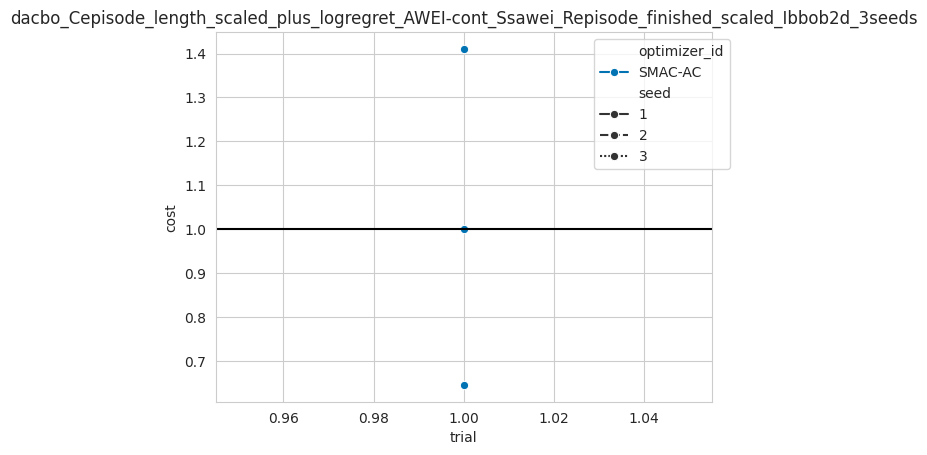

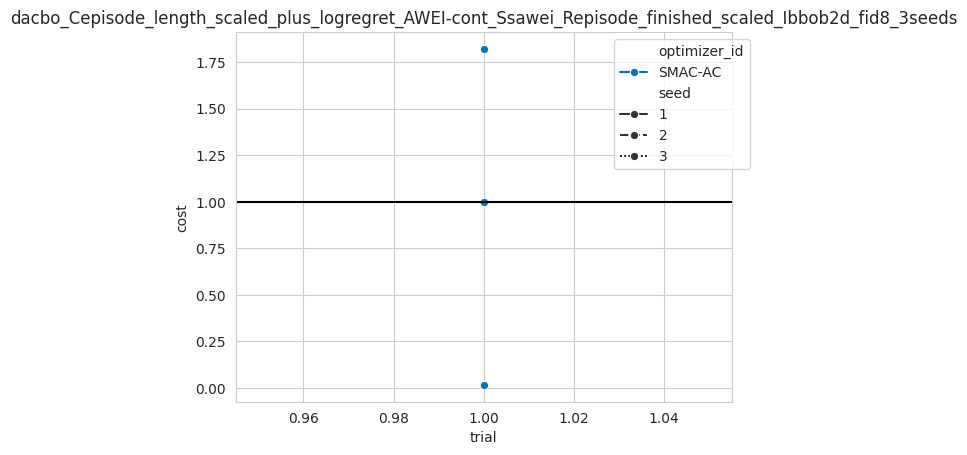

In [10]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from carps.analysis.utils import setup_seaborn
import importlib
import dacboenv.experiment.collect_incumbents as ci
importlib.reload(ci)
from dacboenv.experiment.collect_incumbents import gather_data_smac

rundir = Path("../runs/SMAC-AC")

gather_data_smac(rundir)

trajectory_df = pd.read_csv(rundir / "trajectory.csv")
configs_inc_df = pd.read_csv(rundir / "configs_inc.csv")

setup_seaborn()
for task_id, group in trajectory_df.groupby("task_id"):
    if "sawei" not in task_id:
        continue
    ax = sns.lineplot(data=group, x="trial", y="cost", hue="optimizer_id", style="seed", marker="o")
    ax.axhline(1, color="black")
    ax.legend(bbox_to_anchor=(1.05, 1))
    ax.set_title(task_id)
    plt.show()

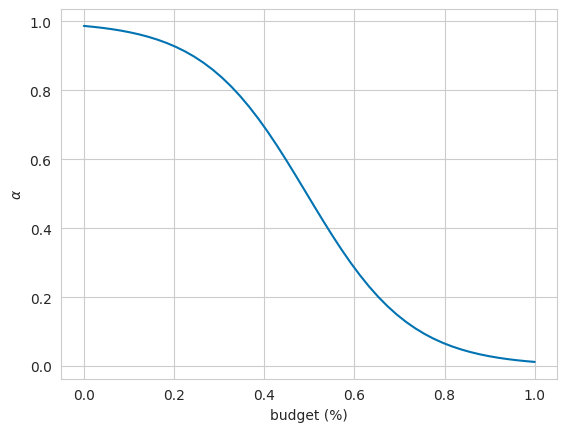

In [2]:
import numpy as np
from dacboenv.utils.math import sigmoid
X = np.linspace(0, 1)
y = sigmoid(-8.7 * X + 4.3)
plt.plot(X, y)
plt.xlabel("budget (%)")
plt.ylabel("$\\alpha$")
plt.show()

['w0', 'w1']


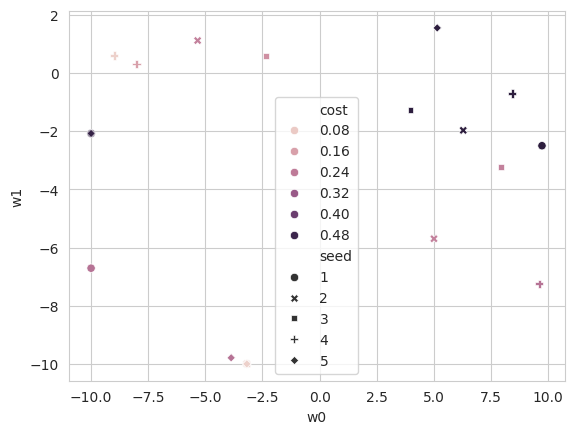

In [3]:
import numpy as np

search_space_dim = 2
sub_df = configs_inc_df[configs_inc_df["search_space_dim"] == search_space_dim]
hp_names = [c for c in sub_df.columns if c.startswith("w")][:search_space_dim]
print(hp_names)
configuration_dicts = [dict(sub_df.iloc[idx][hp_names]) for idx in range(len(sub_df))]
X = np.array([list(d.values()) for d in configuration_dicts])  # (n_samples, n_features)
y = sub_df["cost"].to_numpy()    # class labels (n_samples,)

ax = sns.scatterplot(sub_df, x="w0", y="w1", hue="cost", style="seed")


/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


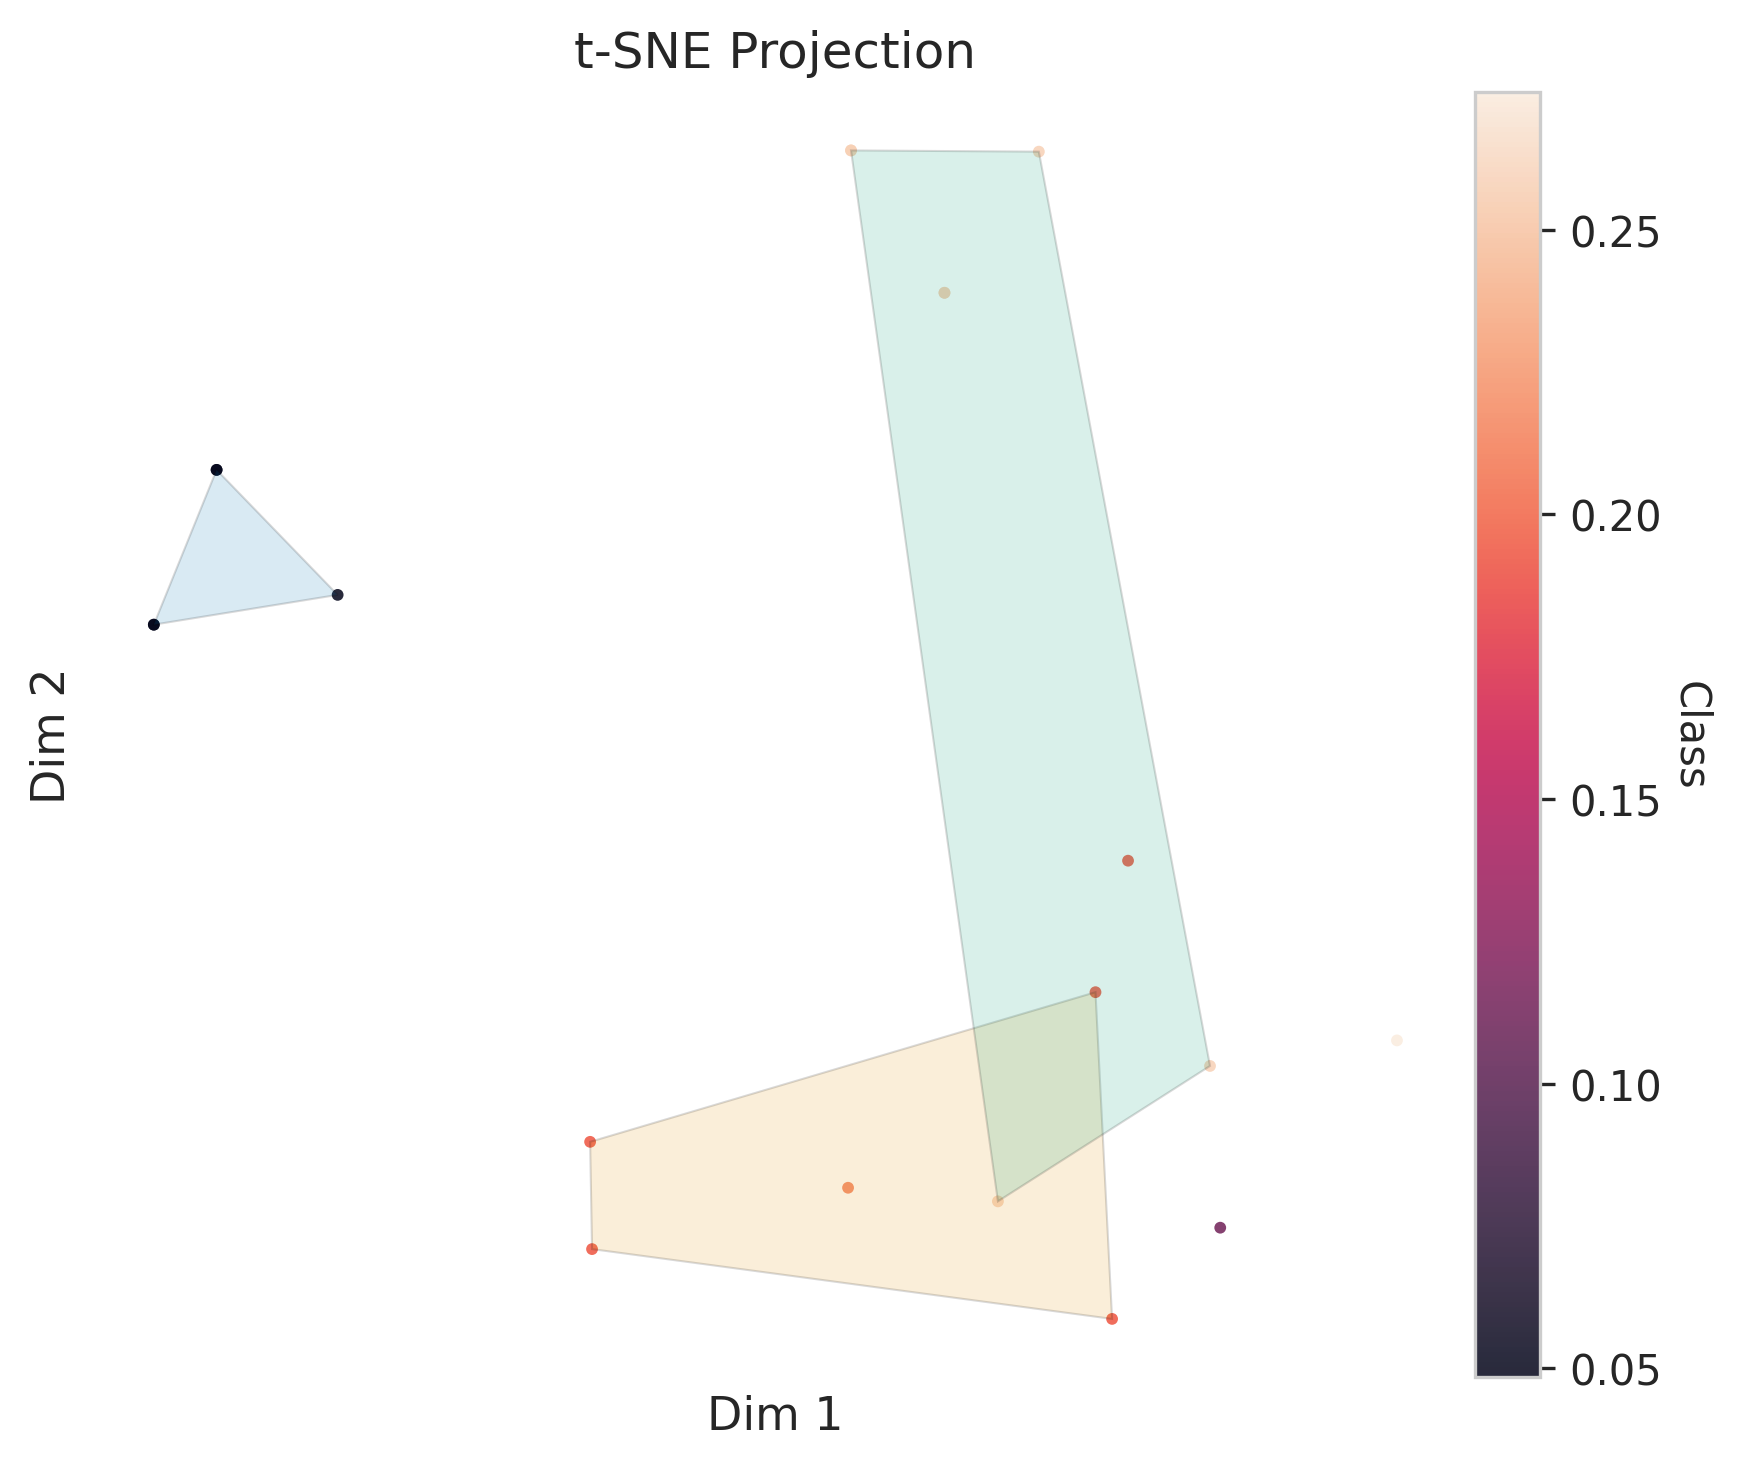

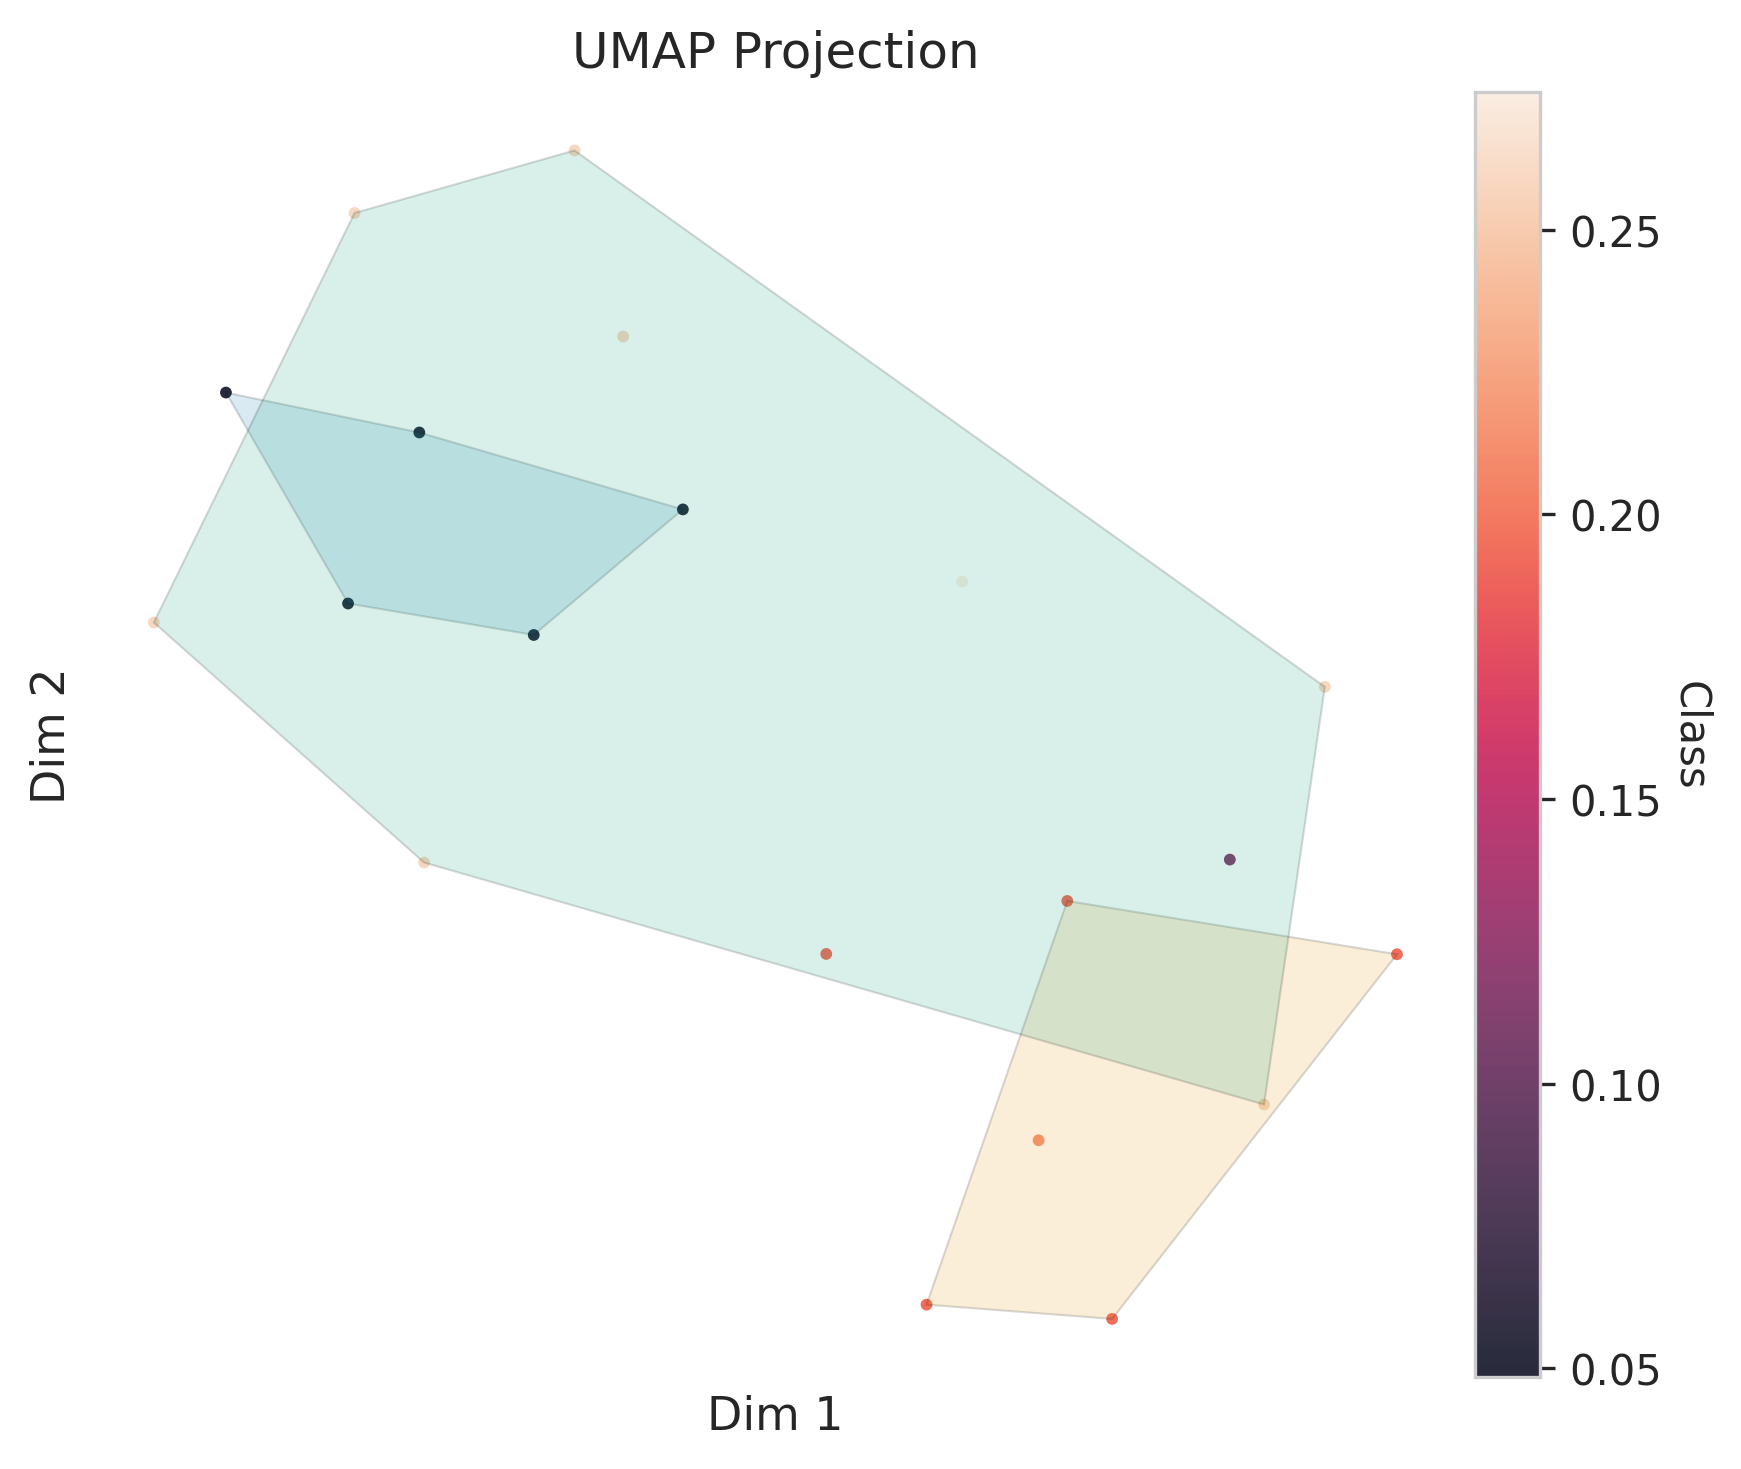

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from scipy.spatial import ConvexHull

random_state = 455684

# -----------------------------
# Input
# -----------------------------
sub_df = configs_inc_df[configs_inc_df["search_space_dim"] == 8]
hp_names = [c for c in sub_df.columns if c.startswith("w")]
configuration_dicts = [dict(sub_df.iloc[idx][hp_names]) for idx in range(len(sub_df))]
X = np.array([list(d.values()) for d in configuration_dicts])  # (n_samples, n_features)
y = sub_df["cost"].to_numpy()    # class labels (n_samples,)

# -----------------------------
# Normalize + PCA
# -----------------------------
X_norm = StandardScaler().fit_transform(X)

X_pca = PCA(
    n_components=min(50, X_norm.shape[1]),
    random_state=42
).fit_transform(X_norm)

# -----------------------------
# Embeddings
# -----------------------------
tsne = TSNE(
    n_components=2,
    perplexity=5,
    learning_rate="auto",
    init="pca",
    max_iter=2000,
    random_state=random_state,
)

X_tsne = tsne.fit_transform(X_pca)

umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=random_state,
)

X_umap = umap_model.fit_transform(X_pca)

# -----------------------------
# Plot helper
# -----------------------------
def plot_embedding_with_hulls(X_emb, y, title):
    plt.figure(figsize=(6, 5), dpi=300)

    classes = np.unique(y)
    scatter = plt.scatter(
        X_emb[:, 0],
        X_emb[:, 1],
        c=y,
        s=8,
        alpha=0.85,
        linewidths=0,
    )

    # Confidence hulls (convex hulls)
    for cls in classes:
        pts = X_emb[y == cls]
        if pts.shape[0] < 3:
            continue  # hull needs >= 3 points

        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices]

        plt.fill(
            hull_pts[:, 0],
            hull_pts[:, 1],
            alpha=0.15,
            edgecolor="black",
            linewidth=0.5,
        )

    cbar = plt.colorbar(scatter, pad=0.01)
    cbar.set_label("Class", rotation=270, labelpad=12)

    plt.xlabel("Dim 1", fontsize=11)
    plt.ylabel("Dim 2", fontsize=11)
    plt.title(title, fontsize=12)

    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.tight_layout()
    plt.show()

# -----------------------------
# Plots
# -----------------------------
plot_embedding_with_hulls(X_tsne, y, "t-SNE Projection")
plot_embedding_with_hulls(X_umap, y, "UMAP Projection")
